# ***NLP Machine Learning Model Project*** 


This project is under the mentorship by Dr. Xu Wang, currently the software engineer in Google Dublin office. The project uses the Consumer Complaint Database (n=2,418,392, k=18) of credit products from Consumer Financial Protection Bureau (CFPB).

The project workflow takes reference from the following examples/tutorials:
#
https://www.analyticsvidhya.com/blog/2021/06/text-preprocessing-in-nlp-with-python-codes/
#
https://medium.com/@datamonsters/text-preprocessing-in-python-steps-tools-and-examples-bf025f872908
#
https://github.com/kapadias/mediumposts/blob/master/natural_language_processing/topic_modeling/notebooks/Introduction%20to%20Topic%20Modeling.ipynb

In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy


In [2]:
import sklearn
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.cluster import hierarchy
from math import ceil, floor

%matplotlib inline

plt.style.use('seaborn-white')

In [3]:
import nltk
nltk.download('stopwords')
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer, PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfTransformer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yanlinzhang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from textblob import TextBlob

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, cross_val_score

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
import re
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [9]:
df = pd.read_csv("/Users/yanlinzhang/ProjectExample/complaints 2.csv")

In [10]:
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2019-06-13,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,CAPITAL ONE FINANCIAL CORPORATION,PA,18640,NaN,Consent not provided,Web,2019-06-13,Closed with explanation,Yes,NaN,3274605
1,2019-11-01,Vehicle loan or lease,Loan,Struggling to pay your loan,Denied request to lower payments,I contacted Ally on Friday XX/XX/XXXX after fa...,Company has responded to the consumer and the ...,ALLY FINANCIAL INC.,NJ,08854,NaN,Consent provided,Web,2019-11-01,Closed with explanation,Yes,NaN,3425257
2,2019-04-01,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account status incorrect,NaN,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",PA,19067,NaN,Consent not provided,Web,2019-04-01,Closed with explanation,Yes,NaN,3198225
3,2019-07-09,Student loan,Federal student loan servicing,Dealing with your lender or servicer,Don't agree with the fees charged,I was contacted about student loan consolidati...,Company believes it acted appropriately as aut...,Equitable Acceptance Corp,TX,75039,NaN,Consent provided,Web,2019-07-09,Closed with explanation,Yes,NaN,3300773
4,2019-08-08,Mortgage,Conventional home mortgage,Trouble during payment process,NaN,NaN,Company has responded to the consumer and the ...,"FLAGSTAR BANK, FSB",ID,83706,NaN,NaN,Referral,2019-08-15,Closed with explanation,Yes,NaN,3342290


## 1. Text Preprocessing ##

### 1.1 Data Undersampling ###

Three raw variables will be (transformed) used in the modeling later: "Issue", "Sub-issue", "Consumer Complaint Narrative". I will explain the supervised learning model in later sections, but since the dependent variable will be the sentiment polarity score of "Consumer Complaint Narrative" and the independent variable X will be a sparse matrix stacking the tf-idf vectorized matrices of all three variables, I chose to simply undersample the imbalanced data, which is just to drop 1,572,930 rows from "Issue" and "Sub-issue" that both miss values from "Consumer Complaint Narrative", for the purpose of this project. An oversampling alternative could be employed in the future if necessary.

In [11]:
# Check missing values
df.isnull().sum()

Date received                         0
Product                               0
Sub-product                      235164
Issue                                 0
Sub-issue                        642720
Consumer complaint narrative    1574930
Company public response         1429558
Company                               0
State                             38596
ZIP code                          38809
Tags                            2126380
Consumer consent provided?       736491
Submitted via                         0
Date sent to company                  0
Company response to consumer          3
Timely response?                      0
Consumer disputed?              1649933
Complaint ID                          0
dtype: int64

In [12]:
# Create a new dataframe with only variables that will be used
IV = df[['Issue','Sub-issue','Consumer complaint narrative']]
IV.dropna(inplace=True)

### 1.2 Punctuation Removal ###

The very first step here to preprocess our main text column is to remove the punctuation using the popular string.punctuation function, where the dictionary contains the following punctuations: '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'. Any punctuations covered by the very dictionary will be removed from the texts.

In [13]:
# Define a function to remove punctuations included in the string.puntuation dictionary
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree

# Store the puncutation-removed documents into a new column
IV['complaint_nopunc']=IV['Consumer complaint narrative'].apply(lambda x:remove_punctuation(x))

### 1.3 Lowercasing ###

Also very straightforwardly, the complaint narrative texts are then converted into the lowercases. This is not necessarily required, but our project focuses more on the actual content of complaints rather than primarily emotions (though important as well).

In [14]:
# Store the lowercased documents into a new column
IV['complaint_lower']=IV['complaint_nopunc'].apply(lambda x: x.lower())

### 1.4 Stopwords Removal ###

This step is to remove the stopwords, usually commonly used words that do not add much value to the analysis. Similar to most other text analysis, the popular NLTK stopword dictionary is used here, including, for example, personal pronouns like "i", "you", "we" and their inflections.

Note that I extended the stopword list by adding x's, which are used to censor private or sensitive information from clients, like addresses. Likewise, for the purpose of our analysis, those x's carry less or no meaning.

The table below is a comparison of before and after stopword removal of three randomly chosen complaint texts. The difference is pretty obvious.

In [15]:
# Call the NLTK stopwords dictionary and append a few x's that are specifically applicable to our complaint documents
stop_words = stopwords.words('english')
stop_words.extend(['x','xx','xxx','xxxx','xxxxx','xxxxxx','xxxxxxx','xxxxxxxx'])

# Store the stopword-removed documents into a new column
IV['complaint_nosw'] = IV['complaint_lower'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))

In [16]:
# Pull up a few documents before and after stopword removal
compare = IV[['complaint_lower','complaint_nosw']].head(3)
compare.style.set_properties(**{'width':'500px'})

,complaint_lower,complaint_nosw
1,i contacted ally on friday xxxxxxxx after falling behind on payments due to being out of work for a short period of time due to an illness i chated with a representative after logging into my account regarding my opitions to ensure i protect my credit and bring my account current she advised me that before an extenstion could be done i had to make a payment in the amount of 27000 i reviewed my finances as i am playing catch up on all my bills and made this payment on monday xxxxxxxx this rep advised me once this payment posts to my account to contact ally back for an extention or to have a payment deffered to the end of my loan with this in mind i contacted ally again today and chatted with xxxx i explained all of the above and the information i was provided when i chatted with the rep last week she asked several questions and advised me that a one or two month extensiondeffered payment could be done however partial payment is needed what she advised me 23000 or there abouts would be due within 10 days from me accepting the agreement and then the remaining bal of 15000 or there abouts would be due in xxxxxxxx in xxxxxxxx my payments of 38000 per month would resume if this was the case i should have just been offered this when i just made my payment so that i could catch up on my bills this company was working with xxxx in new jersey which has since closed most likely due to illegal practices they changed my loan company to this company after i had signed paperwork for another kill you with interest rates and has never once considered refiancing my vechile for a lower interest rate due to the age of the vechile other companies will not take it and they do not work with you,contacted ally friday falling behind payments due work short period time due illness chated representative logging account regarding opitions ensure protect credit bring account current advised extenstion could done make payment amount 27000 reviewed finances playing catch bills made payment monday rep advised payment posts account contact ally back extention payment deffered end loan mind contacted ally today chatted explained information provided chatted rep last week asked several questions advised one two month extensiondeffered payment could done however partial payment needed advised 23000 abouts would due within 10 days accepting agreement remaining bal 15000 abouts would due payments 38000 per month would resume case offered made payment could catch bills company working new jersey since closed likely due illegal practices changed loan company company signed paperwork another kill interest rates never considered refiancing vechile lower interest rate due age vechile companies take work
3,i was contacted about student loan consolidation i agreed to consolidate my student loans as this would save me money on a monthly basis i was entered into an agreement with a company called equitable acceptance who has been charging me xxxxmonth for the past 18 months to date i have paid this company 88000 and still have an outstanding balance of 91000 which means i will end up paying this company 180000 for document preparation services to consolidate my student loans i was unaware that i would be charged this massive fee had i known i would not have engaged in any agreement that would cost over 180000 after researching this company further they are in active litigation for unfair collection practices and fraudulently charging customers they currently are unaccredited with the xxxx and have an f rating i will be deauthorizing the automatic payments through my bank effective immediately,contacted student loan consolidation agreed consolidate student loans would save money monthly basis entered agreement company called equitable acceptance charging xxxxmonth past 18 months date paid company 88000 still outstanding balance 91000 means end paying company 180000 document preparation services consolidate student loans unaware would charge

### 1.5 WordCloud Visualization ###

Wordcloud is a textual visualization technique where each word is picturized with regard to it's importance/relative weight. 

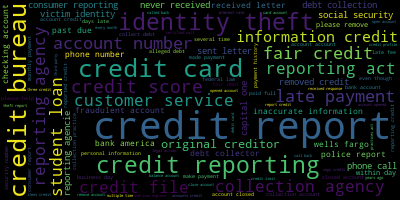

In [17]:
from wordcloud import WordCloud

string = ' '.join(list(IV['complaint_nosw'].values))

wordcloud = WordCloud(background_color = 'black', max_words = 1000,
                      contour_width=5, contour_color='steelblue')

wordcloud.generate(string)

wordcloud.to_image()

### 1.5 Tokenization ###

Tokenization is to split the text into smaller units, words in this case, which is particularly helpful in, for example, computing relative weight of individual words or modeling LDA. The word tokenization package from NLTK is used here.

In [18]:
nltk.download('punkt')
from nltk.tokenize import word_tokenize

# Store the tokenized documents, or tokens, into a new column
IV['complaint_tokenized'] = IV['complaint_nosw'].apply(lambda x: word_tokenize(x))

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/yanlinzhang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### 1.6 Lemmatization ###

Lemmatization is sort of similar to stemming, reducing words to their root or base forms, but one disadvantage of stemming is that the root form of certain words is not formally an English word. On the contrary, lemmatization can ensure that the diminished words do not lose their meanings. It will pass words to pre-defined dictionary that stores the context of words.

In [19]:
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
wordnet = WordNetLemmatizer()

# Define a lemmatizer function using WordNetLemmatizer
def lemmatizer(text):
    lemm_text = [wordnet.lemmatize(word) for word in text]
    return lemm_text

# Store the lemmatized tokens into a new column
IV['complaint_lemmatized']=IV['complaint_tokenized'].apply(lambda x: lemmatizer(x))

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yanlinzhang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 2. Topic Modeling ##

Topic modeling on text data is very much like the clustering analysis with regard to numerical data. It's similar to fuzzy clustering where each data point can belong to more than one subgroup or cluster, while in topic modeling one particular document can be part of multiple topics. As a type of unsupervised learning in the context of text analysis, topic models are used to discover hidden topics or groups of topics based on the text data we have, which enables us to understand the documents better and lots of times to proceed with subsequent supervised modeling procedures.

Latent Dirichlet Allocation (LDA), one of the most frequently used algorithms in topics modeling, is generative probabilistic model for collections of discrete data. LDA is a three-level hierarchical Bayesian model, where each item of a collection is modeled as a finite mixture attributable to one of the underlying set of latent topics. After pre-specifying the number of topics before deploying it, LDA returns the sorted words in each topic with respect to their probability score. 

### 2.1 Prepare for LDA Modeling ###

There are a few preparatory steps before deploying LDA. "Id2word" enables the mapping between normalized words and their integer ids. The "doc2bow" attribute is used to convert the document into the bag-of-words format, i.e., the 2-tuples (token_id, token_count), which in our case is exerted onto the lemmatized complaint narrative documents. Lastly, I specified the number of topics k to be five because it has one of the highest coherence scores, around 0.5. Tuning k is illustrated in section 2.2.

In [20]:
import gensim
import gensim.corpora as corpora

data_words = IV['complaint_lemmatized']

# Map the normalized words and their integer ids
id2word = corpora.Dictionary(data_words)
texts = data_words
# Create a corpus storing bow-converted lemmatized words 
corpus = [id2word.doc2bow(text) for text in texts]

### 2.2 Finding Optimal Number of Topics ###

The way here to ascertain the optimal number of topics in LDA is to run different LDA models with different numbers of topics, k, and see which one returns the highest coherence score. Topic coherence is defined as the measure of score a single topic by measuring the degree of semantic similarity between high scoring words in the topic. In here the "c_v" coherence measure is used, which, by definition, is based on a sliding window, one-set segmentation of the top words and an indirect confirmation measure that uses normalized pointwise mutual information and the cosine similarity. The higher the coherence score an LDA model returns, the more coherent, and usually the better the model is in clustering groups of topics.

Similar to the elbow curve of choosing the optimal k in the context of k-means clustering, the elbow curve of LDA visualizes the trend of changing coherence score when the number of topics increases. It makes sense to pick the k with relatively higher coherence score (not necessarily the highest) but also marks an "elbow" turning point where the topic coherence curve starts to flatten out. If some keywords appear repetitively in multiple topics, then the LDA might allocate too many topics even if the coherence score is rather high. An optimal LDA model ideally should be both coherent and have distinct words in each topic it partitions.

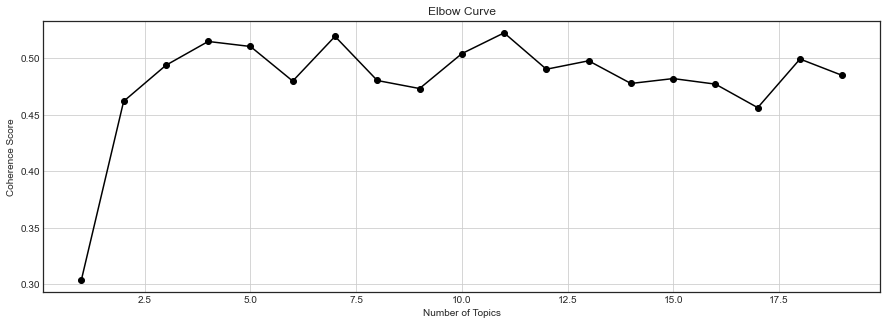

In [23]:
coherence_score = []

# Formulate a for loop iterating LDA & coherence modeling over a sequence of k from 1 to 20
for k in range (1, 20):
    lda_tune = gensim.models.LdaMulticore(corpus=corpus,
                                 id2word=id2word,
                                 num_topics=k)
    coherence_tune = CoherenceModel(model=lda_tune, texts=data_words,
                                    dictionary = id2word, coherence='c_v')
    coherence_score.append(coherence_tune.get_coherence())

# Visualize an Elbow Curve of coherence score against number of topics
fig = plt.figure(figsize=(15, 5))
plt.plot(range(1, 20), coherence_score, marker='o',color='black')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Elbow Curve') 
plt.grid(True)
    

From the Elbow Curve above, a reasonable k would be 7, which means seven topics in the LDA model will return one of those higher coherence scores and will simultanously have more distinct words in each topic. Note that the elbow curve of LDA is display an increasing concave shape very roughly, which makes the choice of k harder and more subjective. K=7, if not the best, is at least a very acceptable choice right here.

## 2.3 Building LDA Model ##

With number of topics specified, we can proceed with the model construction. Again, id2word is the dictionary mapping tokens to the corresponding token id's, and corpus is the list storing tuples obtained from converting documents into the bag-of-words (BoW) format.

In [29]:
from pprint import pprint

# Pre-specify the paramter k
topics = 7

# Deploy LDA model
lda = gensim.models.LdaMulticore(corpus=corpus,
                                 id2word=id2word,
                                 num_topics=topics)

pprint(lda.print_topics())

[(0,
  '0.021*"letter" + 0.017*"day" + 0.015*"credit" + 0.014*"received" + '
  '0.012*"sent" + 0.011*"dispute" + 0.010*"account" + 0.010*"response" + '
  '0.008*"30" + 0.008*"well"'),
 (1,
  '0.021*"account" + 0.016*"bank" + 0.012*"card" + 0.009*"told" + '
  '0.009*"credit" + 0.008*"would" + 0.008*"time" + 0.008*"called" + '
  '0.007*"back" + 0.007*"check"'),
 (2,
  '0.028*"payment" + 0.019*"loan" + 0.013*"credit" + 0.012*"account" + '
  '0.012*"would" + 0.010*"time" + 0.008*"month" + 0.008*"call" + 0.008*"pay" + '
  '0.008*"told"'),
 (3,
  '0.063*"credit" + 0.052*"account" + 0.047*"report" + 0.018*"information" + '
  '0.017*"reporting" + 0.011*"bureau" + 0.009*"collection" + 0.009*"reported" '
  '+ 0.009*"removed" + 0.009*"identity"'),
 (4,
  '0.048*"consumer" + 0.040*"information" + 0.023*"agency" + 0.015*"number" + '
  '0.015*"reporting" + 0.014*"call" + 0.014*"identity" + 0.013*"section" + '
  '0.012*"theft" + 0.012*"company"'),
 (5,
  '0.044*"credit" + 0.026*"report" + 0.026*"acco

From the LDA output, we can try to interpret some of the topics LDA provides. For example, Topic 1 is represented by '0.021*"account" + 0.016*"bank" + 0.012*"card" + 0.009*"told" + ''0.009*"credit" + 0.008*"would" + 0.008*"time" + 0.008*"called" + ''0.007*"back" + 0.007*"check"'. It means the top 10 keywords in this particular topic are "account", "bank", "card", and so on. Topic 1, therefore, is probably focusing on personal bank transactions. Other topics could also be inferred from the corresponding top 10 keywords.

Although there are some of the common words appearing in multiple topics like "credit" and "account", they are intuitively frequent occurrences in coherent narrative regarding credit products. That is to say, the seven topics our LDA model offers are relatively unique and should represent different focuses.

In [31]:
from gensim.models import CoherenceModel

print('\nPerplexity: ', lda.log_perplexity(corpus))

coherence_lda = CoherenceModel(model=lda, texts=data_words,
                               dictionary=id2word, coherence='c_v')
coherence = coherence_lda.get_coherence()
print('\nCoherence Score: ', coherence)


Perplexity:  -7.081375466056208

Coherence Score:  0.4838501413793184


In [42]:
import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
visual = pyLDAvis.gensim_models.prepare(lda, corpus, id2word)
visual


/Users/yanlinzhang/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/yanlinzhang/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/yanlinzhang/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/yanlinzhang/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/yanlinzhang/opt/anaconda3/lib/python3.8/site-

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.147071  0.030440       1        1  24.487724
2      0.145387  0.026392       2        1  23.120587
3     -0.004430 -0.089231       3        1  16.370753
6     -0.148414  0.008125       4        1  12.786862
5     -0.043999 -0.079314       5        1  11.010885
0     -0.014414 -0.038656       6        1   7.274910
4     -0.081201  0.142244       7        1   4.948279, topic_info=            Term          Freq         Total Category  logprob  loglift
167     consumer  2.490900e+05  2.490900e+05  Default  30.0000  30.0000
31        credit  1.288032e+06  1.288032e+06  Default  29.0000  29.0000
200       report  7.394130e+05  7.394130e+05  Default  28.0000  28.0000
49   information  5.415360e+05  5.415360e+05  Default  27.0000  27.0000
402         debt  4.577870e+05  4.577870e+05  Default  26.0000  26.0000
..           ...           ...           ...      ...      ...      ...
681      address  1.260222e+04  1.405182e+05   Topic7  -5.3456   0.5947
319         name  1.270559e+04  1.612261e+05   Topic7  -5.3374   0.4654
31        credit  1.654155e+04  1.288032e+06   Topic7  -5.0736  -1.3489
238            3  1.129920e+04  1.082747e+05   Topic7  -5.4548   0.7462
33           day  1.137393e+04  2.759149e+05   Topic7  -5.4482  -0.1826

[740 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
1069      1  0.055142   000
1069      2  0.191272   000
1069      3  0.607153   000
1069      4  0.006482   000
1069      5  0.005935   000
...     ...       ...   ...
236       3  0.238384  year
236       4  0.026001  year
236       5  0.028078  year
236       6  0.020599  year
236       7  0.018118  year

[3198 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 4, 7, 6, 1, 5])

## 3. Sentiment Analysis ##

### 3.1 TextBlob Sentiment Polarity ###

TextBlob is a Python library for processing textual data, and in here I'm using sentiment.polarity property which returns a document's polarity score within the rage [-1.0, 1.0], where -1.0 is very negative and 1.0 is very positive. Note that the original complaint narrative column is used here rather than the lemmatized complaint because it makes a lot more sense to capture the sentiment polarity of original documents with certain tone, linguistic subtlety, and coherent content being kept.

The second cell is meant to label the complaints into three categories: "Positive", "Negative", and "Neutral", based on the polarity score. This is also a preliminary step for comparing with another library: VADER, and possibly supervised learning models as well where the "sentiment1" column could be the target of classification.

In [25]:
# Define a function to compute TextBlob sentiment polarity scores correspond to each document
def senti(x):
    return TextBlob(x).sentiment.polarity

# Store the TextBlob polarity scores into a new column    
IV['score1']=IV['Consumer complaint narrative'].apply(lambda x:senti(x))

In [26]:
# Define a function to classify documents into categories based on polarity scores
def analysis(x):
    if x < 0:
        return 'Negative'
    elif x == 0:
        return 'Neutral'
    else:
        return 'Positive'

# Store the labels into a new column
IV['sentiment1']=IV['score1'].apply(lambda x: analysis(x))

### 3.2 VADER Compound Score ###

Valence Aware Dictionary and sEntiment Reaonser (VADER) is a lexicon and rule-based sentiment analysis tool, frequently used to analyze social media posts or tweets. The Sentiment Intensity Analyzer returns the intensity scores of negative, neutral, and positive components of a document that add up to one, as well as a compound score used to draw the overall sentiment, within the range of [-1.0, 1.0], which is comparable to the TextBlob polarity score. 

Similar procedure is repeated down here: compute the VADER compound scores corresponding to complaint narrative documents, and label the complaints into three categories: "Positive", "Negative", and "Neutral" based on the compound scores. Note that compounds scores higher or equal to 0.5 is considered positive, those lower or equal to -0.5 is considered negative, and any scores in-between correspond to neutral sentiment.

In [28]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Define a function to compute VADER sentiment compound scores correspond to each document
analyzer = SentimentIntensityAnalyzer()
def vader(x):
    vs = analyzer.polarity_scores(x)
    return vs['compound']

# Store the VADER compound scores into a new column
IV['score2'] = IV['Consumer complaint narrative'].apply(vader)

In [30]:
# Define a function to classify documents into categories based on compound scores
def vader_analysis(compound):
    if compound >= 0.5:
        return "Positive"
    elif compound <= -0.5:
        return "Negative"
    else:
        return "Neutral"

# Store the labels into a new column
IV['sentiment2']=IV['score2'].apply(lambda compound: vader_analysis(compound))

### 3.3 Comparison of Two Methods ###

In [33]:
# Group the polarity and compound scores by their labels (positive, neutral, or negative)
tb_counts = IV['sentiment1'].value_counts().sort_index(ascending=False)
vader_counts = IV['sentiment2'].value_counts().sort_index(ascending=False)

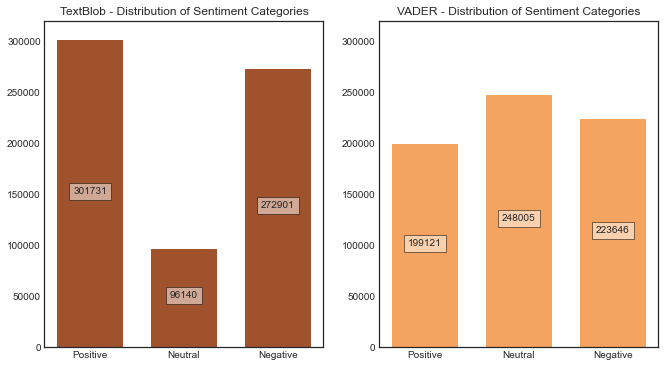

In [34]:
# Define a function to add value labels covered in rectangular box at the center of the height
# of each bar of bar chart
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]//2, y[i], ha = 'center',
                 Bbox = dict(facecolor = 'white', alpha = 0.5))

if __name__ == '__main__':

    x = tb_counts.index
    y = tb_counts.values

    plt.figure(figsize=(17,6))
    
    # Create two subplots each visualizing the counts distribution of sentiment labels
    # Set ylim to let both subplots be to the same scale

    plt.subplot(1,3,1)
    plt.title("TextBlob - Distribution of Sentiment Categories")
    plt.bar(x, y, width=0.7, color='sienna')
    addlabels(x, y)
    plt.ylim(0, 320000)

    x = vader_counts.index
    y = vader_counts.values

    plt.subplot(1,3,2)
    plt.title("VADER - Distribution of Sentiment Categories")
    plt.bar(x, y, width=0.7, color='sandybrown')
    addlabels(x, y)
    plt.ylim(0, 320000)


    plt.show()

## 4. Supervised Learning ##

### 4.1 Vectorizing Textual Data ###

TF-IDF (Term Frequency - Inverse Document Frequency) is a weighting scheme that evaluates how relevant a word is to document in a collection of documents. It is a popular statistical measure meant to convert text to numerical format (sparse matrix) for machine learning purposes.

In [35]:
tfidf_vect = TfidfVectorizer(analyzer='word')

# Convert three collections of raw documents to three sparse matrices of TF-IDF features
tfidf_com = tfidf_vect.fit_transform(IV['Consumer complaint narrative'])
tfidf_issue = tfidf_vect.fit_transform(IV['Issue'])
tfidf_sub = tfidf_vect.fit_transform(IV['Sub-issue'])

# Stack three sparse matrices horizontally
tfidfBIG=scipy.sparse.hstack((tfidf_com, tfidf_issue, tfidf_sub))
print("TF-IDF Sparse Matrix Shape: {}".format(tfidfBIG.shape))
print("Number of Features: {}".format(len(tfidf_vect.get_feature_names())))

TF-IDF Sparse Matrix Shape: (670772, 124192)
Number of Features: 408


In [36]:
y = IV['sentiment2']
X = tfidfBIG

# Split the independent and dependent variables into random train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [37]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=500, n_iter=10, random_state=42)
sam = svd.fit_transform(tfidfBIG)

print("original shape: ", tfidfBIG.shape)
print("transformed shape: ", sam.shape)
print("explained variance ratio sum:\n", svd.explained_variance_ratio_.sum())

original shape:  (670772, 124192)
transformed shape:  (670772, 500)
explained variance ratio sum:
 0.8365072811813636


In [38]:
y = IV['sentiment2']
X = sam

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [41]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

param_l2 = {'C': np.arange(1, 200, 1),
            'penalty':['l2'],
            'solver':['saga','newton-cg','liblinear']}

kf = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

grid_l2 = RandomizedSearchCV(LogisticRegression(max_iter=1000), param_l2, cv=kf, verbose=2)
grid_l2.fit(X_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid_l2.best_score_))
print("best parameters: {}".format(grid_l2.best_params_))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ................C=104, penalty=l2, solver=liblinear; total time= 3.1min
[CV] END ................C=104, penalty=l2, solver=liblinear; total time= 3.8min
[CV] END ................C=104, penalty=l2, solver=liblinear; total time= 3.6min
[CV] END ......................C=44, penalty=l2, solver=saga; total time= 1.2min
[CV] END ......................C=44, penalty=l2, solver=saga; total time= 1.2min
[CV] END ......................C=44, penalty=l2, solver=saga; total time= 1.2min
[CV] END ......................C=18, penalty=l2, solver=saga; total time= 1.2min
[CV] END ......................C=18, penalty=l2, solver=saga; total time= 1.2min
[CV] END ......................C=18, penalty=l2, solver=saga; total time= 1.1min
[CV] END .................C=84, penalty=l2, solver=liblinear; total time= 3.1min
[CV] END .................C=84, penalty=l2, solver=liblinear; total time= 3.2min
[CV] END .................C=84, penalty=l2, solv